In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.define import *
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 16, 16)
# latt_size = (16, 16, 16, 32)
# latt_size = (16, 16, 16, 16)
# latt_size = (16, 16, 16, 8)
latt_size = (16, 16, 8, 8)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 8)
# latt_size = (8, 16, 16, 32)
# latt_size = (16, 16, 16, 32)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 8, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
# latt_size = (2, 2, 2, 2)
# mass = -3.5
# mass = -0.8
# mass = -0.5
# mass = 0.05
# mass = 0.0
mass = -0.05
# kappa = 0.4
# kappa = 0.125
# kappa = 0.5
kappa = 1 / (2 * mass + 8)
# dtype = torch.complex128
dtype = torch.complex64
# dtype = torch.complex32
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_mg(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
# clover_term = torch.zeros_like(clover_term) # just for test, just wilson

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
verbose = True
tol = 1e-9

Using device: cuda


In [2]:
hopping_plus_list = []
hopping_minus_list = []
for ward in range(4):
    hopping_plus_list.append(wilson.give_hopping_plus(ward=ward, U=U))
    hopping_minus_list.append(wilson.give_hopping_minus(ward=ward, U=U))
Ab = wilson.give_wilson(src=b, U=U, with_I=False)
_Ab = torch.zeros_like(b)
for ward in range(4):
    _Ab += wilson.give_wilson_plus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_plus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
    _Ab += wilson.give_wilson_minus(ward=ward, src=b.reshape(
        [12]+list(U.shape[-4:])), hopping=hopping_minus_list[ward]).reshape([4, 3]+list(U.shape[-4:]))
print(torch.norm(Ab-_Ab).item()/torch.norm(Ab).item())

1.1293725763874925e-07


In [3]:
from pyqcu.ascend import inverse
mg = inverse.mg(lat_size=latt_size,dtype=dtype,device=device, wilson=wilson, U=U,
                clover=clover, clover_term=clover_term, tol=tol, verbose=verbose)
mg.init()

self.dof_list:[12, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]
self.dtype_list:[torch.complex64, torch.complex64, torch.complex64, torch.complex64, torch.complex64, torch.complex64]
self.device_list:[device(type='cuda'), device(type='cuda'), device(type='cuda'), device(type='cuda'), device(type='cuda'), device(type='cuda')]
self.lat_size_list:[[16, 16, 8, 8], [8, 8, 4, 4], [4, 4, 2, 2]]
Norm of b:498.4212341308594
Norm of r:703.6323852539062
Norm of x0:442.478271484375
BICGSTAB-Iteration 0: Residual = 1.211823e+02, Time = 0.008780 s
BICGSTAB-Iteration 1: Residual = 3.994273e+01, Time = 0.005143 s
BICGSTAB-Iteration 2: Residual = 8.305371e+01, Time = 0.005048 s
BICGSTAB-Iteration 3: Residual = 1.341712e+01, Time = 0.005397 s
BICGSTAB-Iteration 4: Residual = 9.585194e+00, Time = 0.005090 s
BICGSTAB-Iteration 5: Residual = 5.690652e+00, Time = 0.005040 s
BICGSTAB-Iteration 6: Residual = 5.287696e+00, Time = 0.005375 s
BICGSTAB-Iteration 7: Residual = 4.148746e+00, Time = 0.005660 s
BICGSTAB-I

In [4]:
def matvec(src: torch.Tensor, U: torch.Tensor = U, clover_term: torch.Tensor = clover_term) -> torch.Tensor:
    return wilson.give_wilson(src, U)+clover.give_clover(clover_term=clover_term, src=src)


def _matvec(src: torch.Tensor) -> torch.Tensor:
    return mg.op_list[0].matvec(src=src)

In [5]:
%%time
%time Ab = matvec(b)
%time _Ab = _matvec(b)
print(torch.norm(U).item())
print(torch.norm(clover_term).item())
print(torch.norm(Ab).item())
print(torch.norm(_Ab).item())
print(torch.norm(Ab-_Ab).item()/torch.norm(_Ab).item())

CPU times: user 3.13 ms, sys: 279 μs, total: 3.41 ms
Wall time: 3.15 ms
CPU times: user 1.16 ms, sys: 103 μs, total: 1.26 ms
Wall time: 1.16 ms
443.405029296875
21.315690994262695
496.3869323730469
496.386962890625
9.363828802640598e-08
CPU times: user 7.63 ms, sys: 681 μs, total: 8.32 ms
Wall time: 7.7 ms


In [6]:
%time Ab = matvec(b)
%time _Ab = _matvec(b)

CPU times: user 4.88 ms, sys: 0 ns, total: 4.88 ms
Wall time: 4.25 ms
CPU times: user 1.46 ms, sys: 0 ns, total: 1.46 ms
Wall time: 1.38 ms


In [7]:
b0 = mg.b_list[0]
b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
_b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
_b1 = inverse.restrict(
    local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
print(_b1.flatten()[:100]/b1.flatten()[:100])

tensor([1.0000+2.5224e-08j, 1.0000+4.0161e-08j, 1.0000+6.1576e-09j,
        1.0000+2.2161e-08j, 1.0000+5.3263e-08j, 1.0000-2.5687e-07j,
        1.0000-3.6698e-07j, 1.0000-5.7630e-08j, 1.0000-1.9259e-09j,
        1.0000+6.0790e-08j, 1.0000+1.0366e-07j, 1.0000+2.9774e-09j,
        1.0000-4.3934e-08j, 1.0000-5.4729e-08j, 1.0000-1.9722e-07j,
        1.0000-8.3262e-09j, 1.0000-4.7731e-08j, 1.0000-1.1484e-08j,
        1.0000+4.8916e-08j, 1.0000+2.7588e-08j, 1.0000+7.9702e-08j,
        1.0000-6.3498e-09j, 1.0000-7.9817e-08j, 1.0000+6.2434e-08j,
        1.0000+4.7560e-06j, 1.0000-9.1792e-08j, 1.0000-5.3982e-07j,
        1.0000-1.1684e-07j, 1.0000+3.5109e-08j, 1.0000-1.2585e-07j,
        1.0000-1.6738e-07j, 1.0000-1.2997e-08j, 1.0000+2.5043e-08j,
        1.0000-4.7138e-07j, 1.0000+4.3568e-08j, 1.0000+3.2789e-09j,
        1.0000+8.0516e-08j, 1.0000-6.3353e-08j, 1.0000-1.6315e-07j,
        1.0000+3.1999e-07j, 1.0000+1.2312e-07j, 1.0000-2.2064e-08j,
        1.0000-8.7851e-08j, 1.0000-8.5126e-09j, 

In [8]:
# _x = inverse.cg(b=b, matvec=matvec, tol=tol, verbose=verbose)
_x = inverse.bicgstab(b=b, matvec=_matvec, tol=tol, verbose=verbose)
# _x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, tol=tol, verbose=verbose)

Norm of b:443.18890380859375
Norm of r:666.7212524414062
Norm of x0:443.8825988769531
BICGSTAB-Iteration 0: Residual = 1.445036e+02, Time = 0.005781 s
BICGSTAB-Iteration 1: Residual = 6.485028e+01, Time = 0.006626 s
BICGSTAB-Iteration 2: Residual = 6.179278e+01, Time = 0.006044 s
BICGSTAB-Iteration 3: Residual = 4.319802e+01, Time = 0.006278 s
BICGSTAB-Iteration 4: Residual = 2.650318e+01, Time = 0.006918 s
BICGSTAB-Iteration 5: Residual = 1.924740e+01, Time = 0.005886 s
BICGSTAB-Iteration 6: Residual = 2.503646e+01, Time = 0.006126 s
BICGSTAB-Iteration 7: Residual = 5.927060e+01, Time = 0.005554 s
BICGSTAB-Iteration 8: Residual = 2.820972e+01, Time = 0.006353 s
BICGSTAB-Iteration 9: Residual = 1.075144e+01, Time = 0.006165 s
BICGSTAB-Iteration 10: Residual = 8.466202e+00, Time = 0.005026 s
BICGSTAB-Iteration 11: Residual = 7.248143e+00, Time = 0.004907 s
BICGSTAB-Iteration 12: Residual = 6.072415e+00, Time = 0.004950 s
BICGSTAB-Iteration 13: Residual = 5.391243e+00, Time = 0.005663 s


MG-0:Norm of b:443.18890380859375
MG-0:Norm of r:443.18890380859375
MG-0:Norm of x0:0.0
B-MG-0-BICGSTAB-Iteration 0: Residual = 1.142631e+02
MG-1:Norm of b:62.39340591430664
MG-1:Norm of r:62.39340591430664
MG-1:Norm of x0:0.0
B-MG-1-BICGSTAB-Iteration 0: Residual = 2.144311e+01
MG-2:Norm of b:13.07943058013916
MG-2:Norm of r:13.07943058013916
MG-2:Norm of x0:0.0
B-MG-2-BICGSTAB-Iteration 0: Residual = 5.883525e+00
F-MG-2-BICGSTAB-Iteration 0: Residual = 5.883525e+00, Time = 0.006825 s
B-MG-2-BICGSTAB-Iteration 1: Residual = 4.025826e+00
F-MG-2-BICGSTAB-Iteration 1: Residual = 4.025826e+00, Time = 0.004228 s
B-MG-2-BICGSTAB-Iteration 2: Residual = 3.200905e+00
F-MG-2-BICGSTAB-Iteration 2: Residual = 3.200905e+00, Time = 0.005504 s
B-MG-2-BICGSTAB-Iteration 3: Residual = 2.843512e+00
F-MG-2-BICGSTAB-Iteration 3: Residual = 2.843512e+00, Time = 0.005767 s
B-MG-2-BICGSTAB-Iteration 4: Residual = 5.589237e+00
F-MG-2-BICGSTAB-Iteration 4: Residual = 5.589237e+00, Time = 0.003580 s
B-MG-2-BI

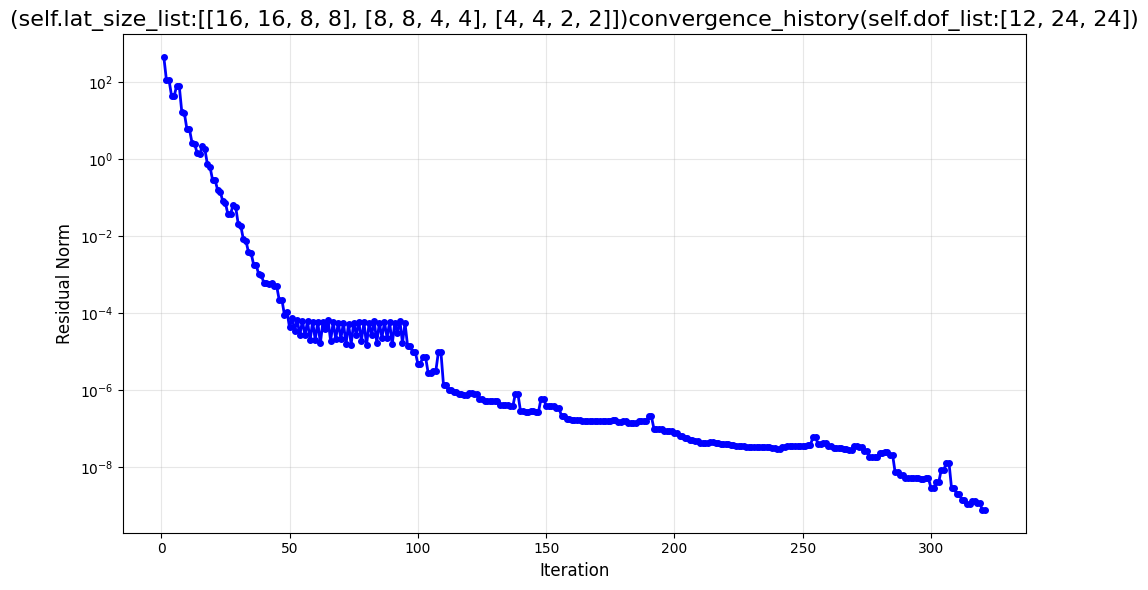

In [9]:
mg.num_levels = 3
mg.convergence_history=[]
# mg.max_iter=50
x = mg.solve(b=b)
mg.plot()

In [10]:
mg.lonv_list[0].shape

torch.Size([24, 12, 4, 2, 4, 2, 8, 2, 8, 2])

In [11]:
(mg.b_list[0]-mg.op_list[0].matvec(x.reshape([12]+list(x.shape[-4:])))).flatten()[:100]

tensor([ 0.0000e+00-3.7253e-08j,  3.7253e-08+1.1921e-07j,
        -8.9407e-08-5.9605e-08j,  7.4506e-08-2.9802e-08j,
        -4.1723e-07+0.0000e+00j, -8.9407e-08-1.1921e-07j,
         3.7253e-08-2.3842e-07j, -1.7881e-07-1.7881e-07j,
         0.0000e+00-1.2666e-07j,  2.9802e-08-8.9407e-08j,
         9.8720e-08+5.9605e-08j,  4.4703e-08-2.3842e-07j,
        -2.9802e-08-1.0431e-07j,  5.9605e-08+7.4506e-09j,
         0.0000e+00-5.9605e-08j,  1.1921e-07+1.4901e-08j,
         5.9605e-08+1.1921e-07j,  0.0000e+00+0.0000e+00j,
        -1.1921e-07-5.9605e-08j,  2.9802e-08+2.9802e-08j,
         1.1921e-07+0.0000e+00j, -5.9605e-08-8.9407e-08j,
        -1.1921e-07+2.9802e-08j,  0.0000e+00+7.0781e-08j,
        -1.1921e-07+0.0000e+00j, -1.1921e-07+1.1921e-07j,
        -2.9802e-08-1.4901e-08j, -1.1921e-07+0.0000e+00j,
         7.4506e-09+5.9605e-08j,  1.1921e-07+2.9802e-08j,
         1.4901e-08-5.9605e-08j, -5.9605e-08+0.0000e+00j,
        -1.4901e-08-2.9802e-08j,  1.4901e-08+1.1921e-07j,
        -5.960

In [12]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

6.789005554928353e-07


In [13]:
mg.num_levels

1

In [14]:
index = 0
null_vecs = mg.nv_list[index]
matvec = mg.op_list[index].matvec
for i in range(null_vecs.shape[0]):
    print(
        f"(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:{(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]}")

(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([-0.0035-0.0532j, -0.0028+0.0256j, -0.0422+0.0033j, -0.0118+0.0185j,
        -0.0036+0.0099j,  0.0112+0.0342j,  0.0484-0.0332j,  0.0261-0.0155j,
        -0.0053-0.0212j,  0.0235-0.0222j], device='cuda:0')
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([ 0.0469-0.0079j, -0.0138-0.0473j,  0.0103+0.0348j,  0.0590-0.0550j,
         0.0218+0.0161j,  0.0235+0.0330j, -0.0363-0.0184j,  0.0169-0.0732j,
         0.0151+0.0359j,  0.0578-0.0153j], device='cuda:0')
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([-0.0290+0.0533j,  0.0045-0.0042j,  0.0029+0.0135j,  0.0365-0.0301j,
        -0.0110+0.0043j, -0.0211+0.0261j,  0.0037-0.0102j,  0.0076-0.0064j,
        -0.0074+0.0034j, -0.0200-0.0018j], device='cuda:0')
(matvec(null_vecs[i])/null_vecs[i]).flatten()[:10]:tensor([-0.3443-0.0555j,  0.0872+0.0137j, -0.0528-0.0016j,  0.0540+0.0836j,
         0.0200-0.0386j, -0.1025-0.0109j,  0.0521+0.0953j, -0.0477+0.0465j,
        

In [15]:
mg.nv_list[-1].flatten()[:100]

tensor([0.0033+0.0064j, 0.0040+0.0068j, 0.0037+0.0063j, 0.0041+0.0061j,
        0.0028+0.0067j, 0.0028+0.0057j, 0.0023+0.0041j, 0.0038+0.0062j,
        0.0036+0.0067j, 0.0042+0.0074j, 0.0033+0.0066j, 0.0027+0.0050j,
        0.0021+0.0063j, 0.0019+0.0058j, 0.0034+0.0058j, 0.0044+0.0081j,
        0.0035+0.0075j, 0.0036+0.0082j, 0.0032+0.0091j, 0.0020+0.0057j,
        0.0025+0.0055j, 0.0029+0.0049j, 0.0031+0.0051j, 0.0028+0.0060j,
        0.0038+0.0072j, 0.0030+0.0071j, 0.0021+0.0086j, 0.0031+0.0066j,
        0.0028+0.0063j, 0.0031+0.0069j, 0.0029+0.0064j, 0.0037+0.0063j,
        0.0042+0.0067j, 0.0036+0.0070j, 0.0035+0.0086j, 0.0028+0.0072j,
        0.0032+0.0070j, 0.0035+0.0075j, 0.0032+0.0071j, 0.0039+0.0084j,
        0.0035+0.0056j, 0.0037+0.0058j, 0.0020+0.0070j, 0.0030+0.0080j,
        0.0038+0.0077j, 0.0034+0.0070j, 0.0031+0.0085j, 0.0033+0.0071j,
        0.0034+0.0077j, 0.0047+0.0076j, 0.0030+0.0074j, 0.0036+0.0080j,
        0.0025+0.0060j, 0.0040+0.0074j, 0.0028+0.0070j, 0.0024+0

In [16]:
_null_vec = torch.randn_like(null_vecs[0])
print(torch.norm(matvec(_null_vec)))
print(matvec(_null_vec).flatten()[:20])
_null_vec -= inverse.bicgstab(b=matvec(_null_vec), matvec=matvec, tol=5e-5)
print(torch.norm(_null_vec))
print(_null_vec.flatten()[:20])
_null_vec/=torch.norm(_null_vec).item()
print(
    f"(matvec(_null_vec)/_null_vec).flatten()[:10]:{(matvec(_null_vec)/_null_vec).flatten()[:10]}")

tensor(496.6351, device='cuda:0')
tensor([-0.9883-0.2849j, -1.1351+0.1133j,  0.9181+0.4774j, -0.5451-0.8867j,
         1.1995+0.5107j,  0.2204+0.5615j,  0.6407-0.6150j,  0.3730+1.2210j,
        -0.2144-0.4590j,  1.0083+0.8976j, -1.2485-0.3553j,  0.0717+0.1640j,
        -0.2806-0.6006j,  0.9533+0.8992j, -0.5829+0.4183j,  0.6482+0.6372j,
         1.4128-0.2464j, -1.3819+0.8826j,  0.1757-0.3264j,  0.1384-0.2902j],
       device='cuda:0')
Norm of b:496.63507080078125
Norm of r:703.0077514648438
Norm of x0:443.7134704589844
BICGSTAB-Iteration 0: Residual = 1.215112e+02, Time = 0.006130 s
BICGSTAB-Iteration 1: Residual = 4.030353e+01, Time = 0.006023 s
BICGSTAB-Iteration 2: Residual = 8.463200e+01, Time = 0.005965 s
BICGSTAB-Iteration 3: Residual = 1.357065e+01, Time = 0.006104 s
BICGSTAB-Iteration 4: Residual = 1.203057e+01, Time = 0.005637 s
BICGSTAB-Iteration 5: Residual = 5.930376e+00, Time = 0.006039 s
BICGSTAB-Iteration 6: Residual = 4.255205e+00, Time = 0.005879 s
BICGSTAB-Iteration 7

In [17]:
_b = torch.randn_like(null_vecs[0])
_x = inverse.bicgstab(b=_b, matvec=matvec, tol=1e-8)
print((_b-matvec(_x)).flatten()[:100])
print(torch.norm(_b))
print(torch.norm(_x))

Norm of b:444.10101318359375
Norm of r:665.2433471679688
Norm of x0:443.0645751953125
BICGSTAB-Iteration 0: Residual = 1.441336e+02, Time = 0.005391 s
BICGSTAB-Iteration 1: Residual = 7.121310e+01, Time = 0.005776 s
BICGSTAB-Iteration 2: Residual = 6.088152e+01, Time = 0.005471 s
BICGSTAB-Iteration 3: Residual = 4.268930e+01, Time = 0.005019 s
BICGSTAB-Iteration 4: Residual = 2.611079e+01, Time = 0.005552 s
BICGSTAB-Iteration 5: Residual = 1.889230e+01, Time = 0.005888 s
BICGSTAB-Iteration 6: Residual = 2.473890e+01, Time = 0.005312 s
BICGSTAB-Iteration 7: Residual = 3.316870e+01, Time = 0.005289 s
BICGSTAB-Iteration 8: Residual = 2.295752e+01, Time = 0.005451 s
BICGSTAB-Iteration 9: Residual = 1.085584e+01, Time = 0.005162 s
BICGSTAB-Iteration 10: Residual = 9.740934e+00, Time = 0.005063 s
BICGSTAB-Iteration 11: Residual = 8.485935e+00, Time = 0.005222 s
BICGSTAB-Iteration 12: Residual = 6.036879e+00, Time = 0.005545 s
BICGSTAB-Iteration 13: Residual = 6.521208e+00, Time = 0.005261 s


In [18]:
_null_vec.flatten()[:100]

tensor([0.0017-1.9968e-04j, 0.0017+1.1860e-04j, 0.0016+2.0331e-04j,
        0.0020-1.1618e-04j, 0.0023-4.6229e-04j, 0.0018-2.0331e-04j,
        0.0018-2.2025e-04j, 0.0020-1.9363e-04j, 0.0018-4.0662e-04j,
        0.0017-2.3235e-04j, 0.0022-7.7451e-05j, 0.0022-2.9044e-05j,
        0.0018+4.2961e-05j, 0.0016-7.7451e-05j, 0.0015+4.1146e-05j,
        0.0018-2.9044e-04j, 0.0016-3.0497e-04j, 0.0019-2.3235e-04j,
        0.0016-2.7758e-04j, 0.0022-1.1134e-04j, 0.0021-1.2586e-04j,
        0.0018+2.9044e-05j, 0.0018-1.2102e-04j, 0.0019-5.8089e-05j,
        0.0020-6.7770e-05j, 0.0020+1.7911e-04j, 0.0020-8.2292e-05j,
        0.0018-3.0012e-04j, 0.0017+2.9044e-04j, 0.0017+1.2102e-04j,
        0.0019+3.6305e-04j, 0.0019-1.3849e-04j, 0.0015-4.4474e-04j,
        0.0017-2.0815e-04j, 0.0017-3.5337e-04j, 0.0018-5.2280e-04j,
        0.0018+2.3235e-04j, 0.0017-2.1299e-04j, 0.0017-3.6789e-04j,
        0.0017-2.2267e-04j, 0.0021-4.0662e-04j, 0.0024-1.2586e-04j,
        0.0019-2.4204e-05j, 0.0019+1.2102e-04j, 